In [190]:
# import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [191]:
# load dataset 
data= pd.read_csv("laptopData.csv")

In [192]:
# read dataset
data.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1273 non-null   object 
 1   TypeName          1273 non-null   object 
 2   Inches            1273 non-null   object 
 3   ScreenResolution  1273 non-null   object 
 4   Cpu               1273 non-null   object 
 5   Ram               1273 non-null   object 
 6   Memory            1273 non-null   object 
 7   Gpu               1273 non-null   object 
 8   OpSys             1273 non-null   object 
 9   Weight            1273 non-null   object 
 10  Price             1273 non-null   float64
dtypes: float64(1), object(10)
memory usage: 112.1+ KB


In [194]:
data.describe()

,Price
count,1273.000000
mean,59955.814073
std,37332.251005
min,9270.720000
25%,31914.720000
50%,52161.120000
75%,79333.387200
max,324954.720000


In [195]:
data.isnull().sum()

Company             30
TypeName            30
Inches              30
ScreenResolution    30
Cpu                 30
Ram                 30
Memory              30
Gpu                 30
OpSys               30
Weight              30
Price               30
dtype: int64

In [196]:
data.columns.tolist()

['Company',
 'TypeName',
 'Inches',
 'ScreenResolution',
 'Cpu',
 'Ram',
 'Memory',
 'Gpu',
 'OpSys',
 'Weight',
 'Price']

In [197]:
#  Data cleaning and numeric conversions

if 'Unnamed: 0' in df.columns:
    data = data.drop(columns=['Unnamed: 0'])

# to check is Price numeric
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

# RAM convert into numevric 
data['Ram_GB'] = pd.to_numeric(data['Ram'].astype(str).str.replace('GB','', regex=False), errors='coerce')

# Weight convert into numeric 
data['Weight_kg'] = pd.to_numeric(data['Weight'].astype(str).str.replace('kg','', regex=False), errors='coerce')

# Inches into numeric
data['Inches'] = pd.to_numeric(data['Inches'], errors='coerce')

# Memory: parse total GB (handles "128GB SSD + 1TB HDD")
def parse_memory_total_gb(x):
    if pd.isna(x): return np.nan
    s = str(x)
    parts = re.findall(r'(\d+)\s*(TB|GB)', s, flags=re.I)
    total = 0.0
    for num, unit in parts:
        n = float(num)
        if unit.lower().startswith('t'):
            total += n * 1024.0
        else:
            total += n
    return total if total>0 else np.nan

data['Memory_GB'] = data['Memory'].apply(parse_memory_total_gb)

# Small engineered categorical features
data['CPU_Brand'] = data['Cpu'].astype(str).str.split().str[0].fillna('Unknown')
data['GPU_Brand'] = data['Gpu'].astype(str).str.split().str[0].fillna('Unknown')


In [198]:

# Keep only rows that have Price (target must exist)


data = data[data['Price'].notna()].copy()
print("After keeping Price rows:", data.shape)

#  we will use Numeric columns 
num_cols = ['Ram_GB', 'Weight_kg', 'Inches', 'Memory_GB']

# Impute numeric NaNs with median (safe)
imputer = SimpleImputer(strategy='median')
data[num_cols] = imputer.fit_transform(df[num_cols])

# Fill categorical NaNs with 'Unknown'
cat_cols = ['Company','TypeName','CPU_Brand','GPU_Brand','OpSys']
for c in cat_cols:
    if c in data.columns:
        data[c] = data[c].fillna('Unknown')


After keeping Price rows: (1273, 16)


C:\Users\kr304\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


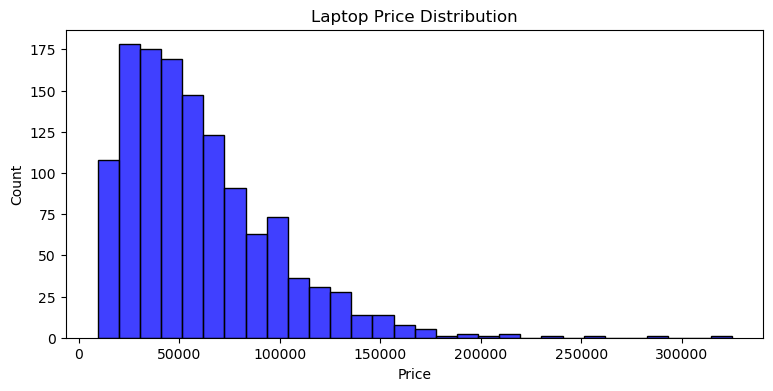

In [199]:

#  Laptop Prices Distribution

plt.figure(figsize=(9,4))
sns.histplot(df["Price"], bins=30, color="b")
plt.title("Laptop Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()



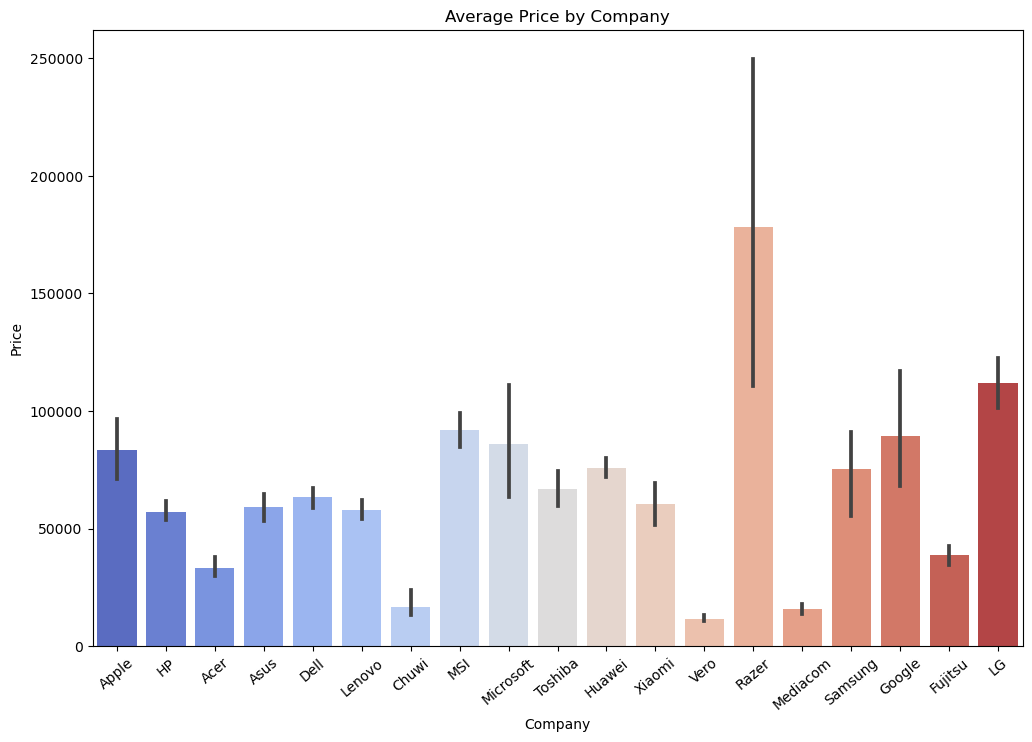

In [200]:
#  Each Company price 
plt.figure(figsize=(12,8))
sns.barplot(x="Company", y="Price", data=data, estimator="mean", palette="coolwarm")
plt.title("Average Price by Company")
plt.xticks(rotation=40)
plt.show()



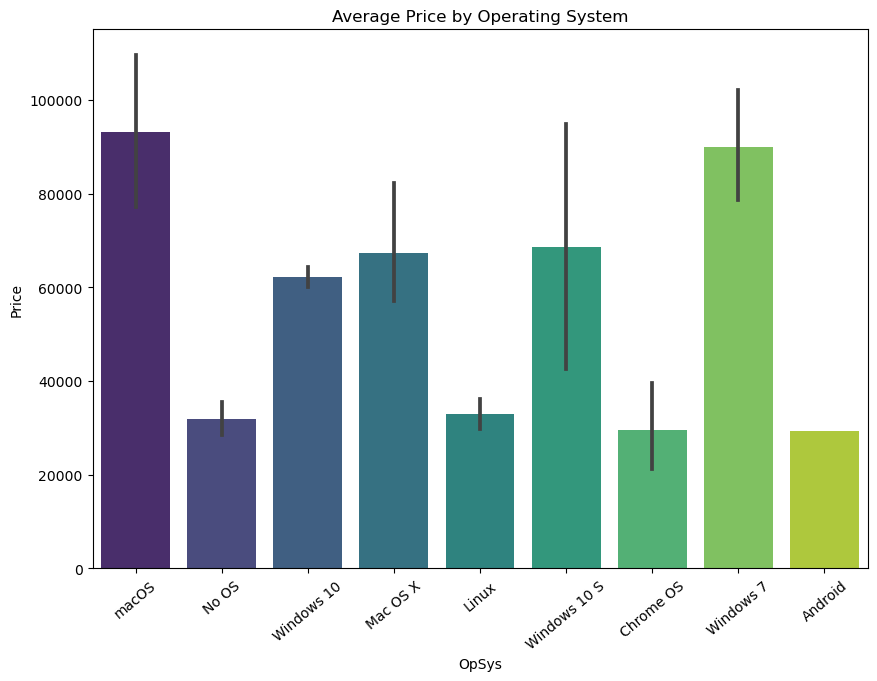

In [201]:
# . Average Price by Operating System
plt.figure(figsize=(10,7))
sns.barplot(x="OpSys", y="Price", data=data, estimator="mean", palette="viridis")
plt.title("Average Price by Operating System")
plt.xticks(rotation=40)
plt.show()

In [202]:
# features and target
features = num_cols + ['Company','TypeName','CPU_Brand','GPU_Brand','OpSys']

X = data[features].copy()
y = data['Price'].copy()

# Convert categorical → dummies (one-hot)
X = pd.get_dummies(X, columns=['Company','TypeName','CPU_Brand','GPU_Brand','OpSys'], drop_first=True)

print("Feature matrix shape:", X.shape)

Feature matrix shape: (1273, 40)


In [203]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1018, 40) Test: (255, 40)


In [204]:
 # Feature importance (top 10)
importances = pd.Series(model.feature_importances_, index=X_train.columns)
top10 = importances.sort_values(ascending=False).head(10)
print(top10)

Ram_GB                  0.568625
Weight_kg               0.142381
Memory_GB               0.051757
TypeName_Notebook       0.049981
Company_Razer           0.040964
Inches                  0.028830
TypeName_Workstation    0.024689
OpSys_Windows 7         0.012317
Company_Asus            0.009825
Company_HP              0.009159
dtype: float64


In [211]:

# Define models

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}

results = []

# Train & evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append((name, rmse, r2))

# Make a results table
results_data = pd.DataFrame(results, columns=["Model", "RMSE", "R2"])
print(results_data.sort_values(by="R²", ascending=False))


               Model          RMSE        R2
2      Random Forest  19847.892655  0.728445
1      Decision Tree  21016.513942  0.695526
0  Linear Regression  22309.658993  0.656905


In [220]:
# CONCLUSION-
# THE BEST RESULT GIVEN BY RANDOM FOREST AS RMSE IS 19847 RUPEES LESS THEN OTHER MODEL
# AND THE VARIANCE (R²) IS 72.8 OR 73%, HIGHER THEN DECISION TREE AND LINAER RIGRESSION 
# IT CAPTURE THE NON-LINEAR RELATIONSHIP BETWEEN FEATURES LIKE RAM, COMPANY, CPU, GPU,
# AND SCREENSIZE, MAKING IT A RELIABLE MODEL FOR PRICE PREDICTION.


In [ ]:
# Features of Random Forest-
# Ensemble Learning Method:-Combines multiple decision trees to improve overall performance.
# Random Feature Selection:-At each node, a random subset of features is selected for splitting, introducing more diversity among trees.
# Handles Classification & Regression:-Versatile for both types of problems.
# Feature Importance Evaluation:-Offers metrics to measure how important each feature is to the model.

In [ ]:
# Advantages of Random Forest-
# High Accuracy:-Often performs better than a single decision tree by reducing variance.
# Handles Missing Values:-Can maintain accuracy even with missing data.
# Works Well with Large Datasets:-Can handle thousands of features and instances.
# Reduces Noise Impact:-Less sensitive to outliers and noise in the data.   

In [ ]:
# Disadvantages of Random Forest-
# Complexity:-Not as interpretable as a single decision tree.
# Slower Prediction Time:-Especially with a large number of trees.
# Memory Intensive:-Requires more memory and computational resources.
# Bias in Imbalanced Data:-May be biased toward the majority class if not properly tuned.

In [ ]:
# Workflow of Random Forest-
    
# Data Preparation-Collect and preprocess the dataset.
# Handle missing values, encode categorical variables, etc.
    
# Bootstrapping-Create multiple subsets (with replacement) from the original dataset.

# Training Decision Trees--For each subset:-Build a decision tree.
# At each node, randomly select a subset of features to determine the best split.

# Voting/Averaging-For classification: Aggregate predictions via majority voting.
# For regression: Aggregate predictions via average of outputs.

# Model Evaluation-Use metrics like accuracy, F1-score (classification) or RMSE, MAE (regression).
# Optionally use Out-of-Bag error for evaluation.
                               
# Feature Importance (Optional)-Extract and visualize the importance of different features in the model.                              